## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. These will be uploaded for you the week of Oct 24th, at which point we'll update this notebook with a link. 

**Update:** This Google Drive [folder](https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no?usp=sharing) contains many additional slides and masks you can use. Note that while the starter code below downloads one slide from a Google Cloud URL (we have hosted this online for you for convenience), you will need to find a way to work with the other slides yourself for practice. You do not need to use them all! Just a few. You can either host the slides you'll use on Cloud storage using any provider, or you can download from Google Drive in your notebook (this may be slow).

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, on any topic of interest to you.

### Submission Details 

#### Name : Prabha Kiranmai Vasireddy 
#### Uni : pv2342


In [2]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
from google.colab import drive
import json
from tqdm import tqdm

### Reading Slide Files from Drive

In [3]:
drive.mount("/content/gdrive", force_remount=True)

slides_directory = "/content/gdrive/MyDrive/Applied_DL_Project/slides"

Mounted at /content/gdrive


In [4]:
tumor_dictionary = {}

for tif_path in os.listdir(slides_directory):
    if "tif" in tif_path and "38" not in tif_path:
        slide_number = re.findall("tumor_(\d+)", tif_path)
        if slide_number:
            slide_number = int(slide_number[0])
            if slide_number not in tumor_dictionary:
                tumor_dictionary[slide_number] = {}

            if "mask" not in tif_path:
                tumor_dictionary[slide_number]["tumor"] = os.path.join(
                    slides_directory, tif_path
                )
            else:
                tumor_dictionary[slide_number]["mask"] = os.path.join(
                    slides_directory, tif_path
                )

In [5]:
# The tumor_dictionary has the slide numbers , their tumor tif files and the mask files in the dictionary.

print(f"The length of the tumor_dictionary is {len(tumor_dictionary)}\n")

print(
    f"The slide numbers present in the tumor_dictionary are : {sorted(list(tumor_dictionary.keys()))}\n"
)

print(f"Example of one entry in the tumor_dictionary is 1: {tumor_dictionary[1]} ")

The length of the tumor_dictionary is 21

The slide numbers present in the tumor_dictionary are : [1, 2, 5, 12, 16, 19, 23, 31, 35, 57, 59, 64, 75, 78, 81, 84, 91, 94, 96, 101, 110]

Example of one entry in the tumor_dictionary is 1: {'mask': '/content/gdrive/MyDrive/Applied_DL_Project/slides/tumor_001_mask.tif', 'tumor': '/content/gdrive/MyDrive/Applied_DL_Project/slides/tumor_001.tif'} 


### Pre-Processing Functions given in Starter Code

In [6]:
# Slide Processing Functions
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert("RGB")  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


# As mentioned in class, we can improve efficiency by ignoring non-tissue areas
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))


def apply_mask(im, mask, color=(255, 0, 0)):
    masked = np.copy(im)
    for x, y in mask:
        masked[x][y] = color
    return masked

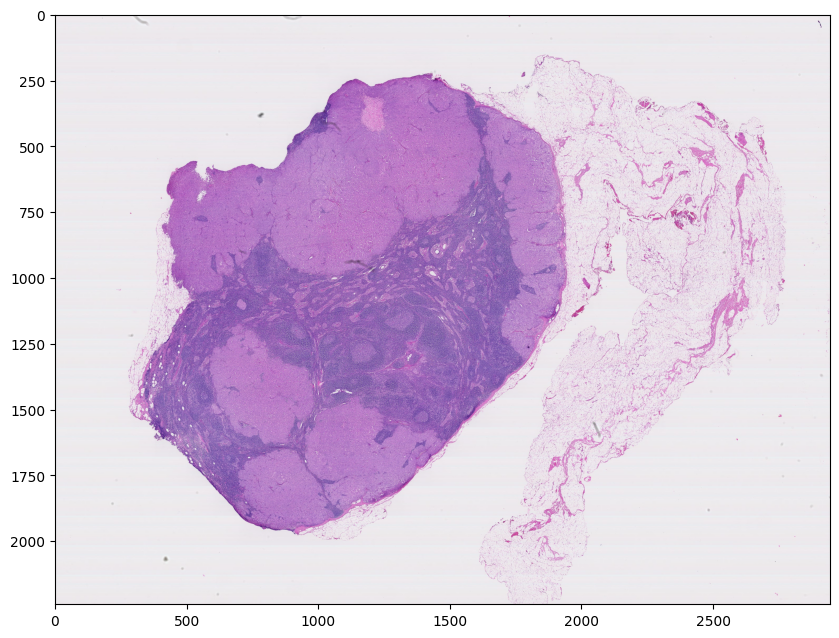

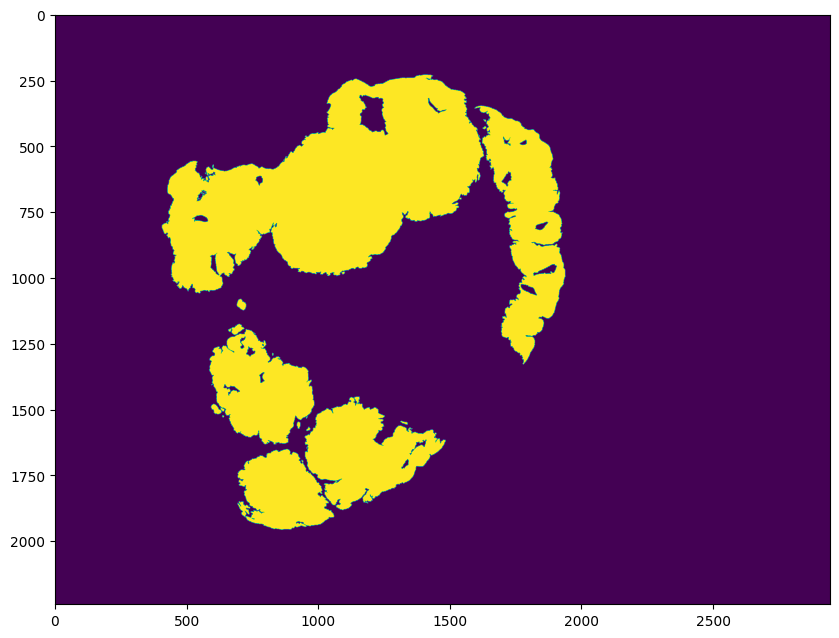

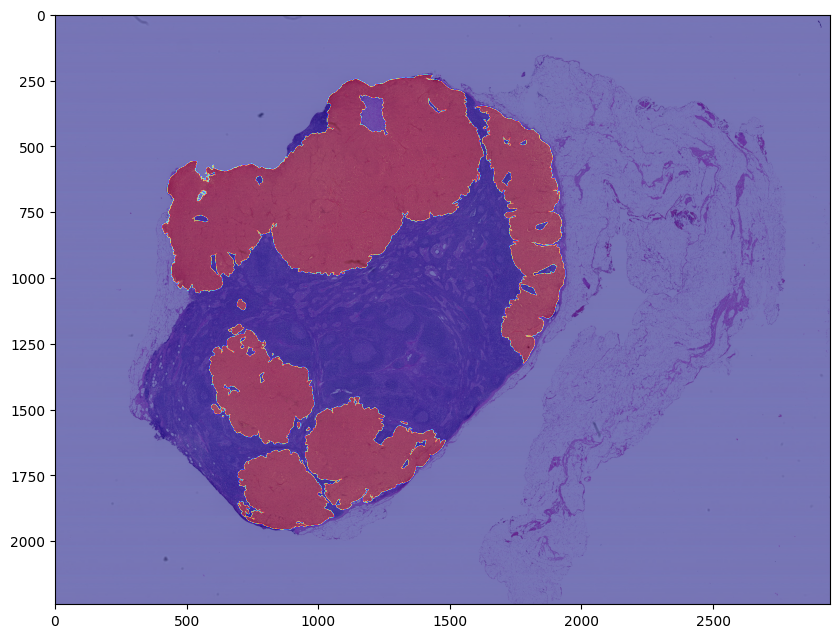

In [11]:
slide_number = 110
slide = open_slide(tumor_dictionary[slide_number]["tumor"])
tumor_mask = open_slide(tumor_dictionary[slide_number]["mask"])

level = 5
slide_image = read_slide(
    slide,
    x=0,
    y=0,
    level=level,
    width=slide.level_dimensions[level][0],
    height=slide.level_dimensions[level][1],
)

mask_image = read_slide(
    tumor_mask,
    x=0,
    y=0,
    level=level,
    width=slide.level_dimensions[level][0],
    height=slide.level_dimensions[level][1],
)

mask_image = mask_image[:, :, 0]

# Plot only slide image
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(slide_image)

# Plot only Red channel of Mask
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(mask_image)

# Plot Slide and overlap Red Channel of Mask
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap="jet", alpha=0.5)  # Red regions contains cancer.

2129295 tissue_pixels pixels (42.4 percent of the image)


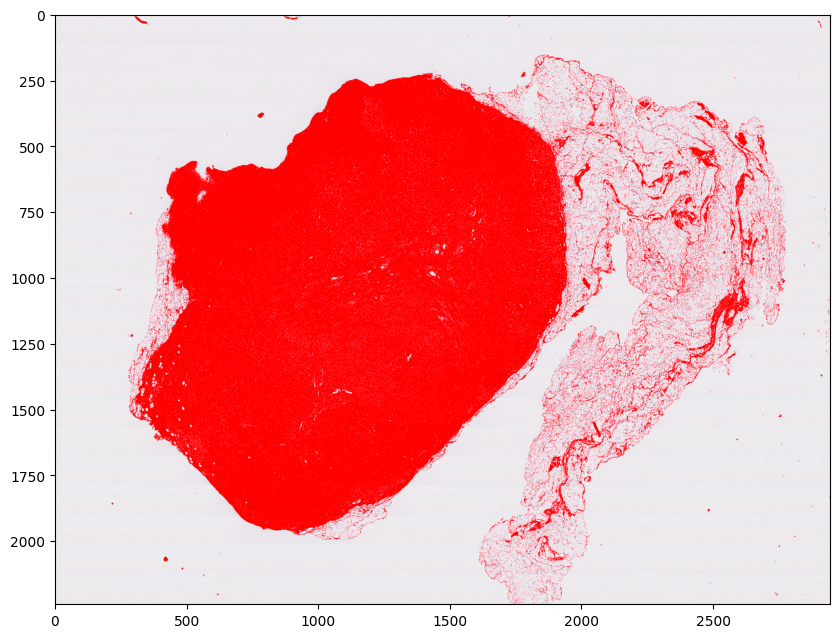

In [ ]:
# Tissue Threshold
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = (
    len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
)
print(
    "%d tissue_pixels pixels (%.1f percent of the image)"
    % (len(tissue_pixels), percent_tissue)
)

tissue_regions = apply_mask(slide_image, tissue_pixels)

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(tissue_regions)

### Create Training, Validation and Test Split 

Training Slides Size : 15 
Validation Slides Size : 2 
Testing Slides Size : 3


In [6]:
rng = np.random.default_rng(seed=42)
slides_set = set(tumor_dictionary.keys())

# Get test_slides
test_set = rng.choice(list(slides_set), 4)
slides_set = slides_set - set(test_set)

# Get validation_slides
validation_set = rng.choice(list(slides_set), 2)
slides_set = slides_set - set(validation_set)

# Get training slides
training_set = list(slides_set)

print(f"Training Set length : {len(training_set)} , slides : {training_set}")
print(f"Validation Set length : {len(validation_set)} , slides : {validation_set}")
print(f"Test Set length : {len(test_set)} , slides : {test_set}")

Training Set length : 15 , slides : [64, 1, 5, 75, 12, 16, 81, 84, 23, 94, 31, 96, 35, 110, 59]
Validation Set length : 2 , slides : [ 19 101]
Test Set length : 4 , slides : [ 2 91 78 57]


With Seed = 42, The split used for model training is as follows

```
Training Set length : 15 , slides : [64, 1, 5, 75, 12, 16, 81, 84, 23, 94, 31, 96, 35, 110, 59]
Validation Set length : 2 , slides : [ 19 101]
Test Set length : 4 , slides : [ 2 91 78 57]
```

### Custom Helper Functions

1. check_center_for_tumor : Check if the center of the path has tumor or not. If tumor present, return True, else False 
2. get_bool_tissue_tumor_pixels : Check if the slide and mask contains tissue and tumor 
3.

In [7]:
def check_center_for_tumor(mask, center_len=128, patch_len=299):
    """
      "For each input patch, we predict the label of the center 128×128 region " - Authors

    Check if the center of the path has tumor or not. If tumor present, return True, else False

    Input :
      1. Mask slide  - Mask slide image - shape (299,299)
      2. Center len  - center size (default 128)
      3. patch len  - patch size (default 299)

    Output :
      1. Bool - True if tumor present in middle, False if tumor not present

    """

    start_coordinates = (patch_len - center_len) // 2
    return np.any(
        mask[
            start_coordinates : start_coordinates + center_len,
            start_coordinates : start_coordinates + center_len,
        ]
        > 0
    )

In [16]:
def get_bool_tissue_tumor_pixels(slide, mask, level=5, half_patch_len=149):
    """
    Check if the slide and mask contains tissue and tumor

    Input :
      1. slide - slide
      2. mask  - mask
      3. level - checking level
      3. half_patch_len = 149

    Output :
      1. normal_bool - True if normal tissues exist else False
      2. tumor_bool - True if tumor tissues exist else False

    """
    width, height = slide.level_dimensions[level]

    # Read the slide and mask
    slide_im = read_slide(slide, x=0, y=0, level=level, width=width, height=height)

    mask_im = read_slide(mask, x=0, y=0, level=level, width=width, height=height)[
        :, :, 0
    ]

    mask_im = mask_im[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
    slide_im = apply_mask(
        slide_im[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len],
        find_tissue_pixels(
            slide_im[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
        ),
    )

    return np.any((slide_im[:, :, 0] - 255 * mask_im) != 0), np.any(mask_im != 0)


def get_tissue_tumor_pixels(slide, mask, level=5, half_patch_len=149):
    """
        Get the pixels at which tissue and tumors are present

    Input :
      1. slide - slide
      2. mask  - mask
      3. level - checking level
      3. half_patch_len = 149

    Output :
      1. normal_pixels - tuples of (x,y) which represent normal tissues
      2. tumor_pixels - tuples of (x,y) which represent tumor tissues

    """

    width, height = slide.level_dimensions[level]

    # Read the slide and mask
    slide_im = read_slide(slide, x=0, y=0, level=level, width=width, height=height)

    mask_im = read_slide(mask, x=0, y=0, level=level, width=width, height=height)[
        :, :, 0
    ]

    mask_im = mask_im[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
    slide_im = apply_mask(
        slide_im[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len],
        find_tissue_pixels(
            slide_im[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
        ),
    )

    tissue_coord, tumor_coord = list(
        zip(*np.nonzero(slide_im[:, :, 0] - 255 * mask_im))
    ), list(zip(*np.nonzero(mask_im)))

    return tissue_coord, tumor_coord

In [21]:
def get_patch(slide, mask, x, y, level, patch_size=299):
    """

    Get patch from slide and tumor_mask from given x,y for the given level

    Input :
        1. slide - slide
        2. mask  - mask
        3. x - x-co-ordinate
        4. y - y - co-ordinate
        3. level - level
        3. patch_size - patch_size

    Output :
      1. slide_image, mask_image

    """

    half_patch_len = int(patch_size // 2 * slide.level_downsamples[level])
    return (
        read_slide(
            slide,
            int(x) - half_patch_len,
            int(y) - half_patch_len,
            level,
            width=patch_size,
            height=patch_size,
        ),
        read_slide(
            mask,
            int(x) - half_patch_len,
            int(y) - half_patch_len,
            level,
            width=patch_size,
            height=patch_size,
        )[:, :, 0],
    )

In [81]:
def generate_dataset(
    tumor_dictionary,
    split,
    levels=None,
    checking_level=5,
    data_points=4000,
    patch_size=299,
):

    """

    Generate Patches from slides and tumors with 50% balanced normal and tumor tissue patches.

    Input :
      tumor_dictionary - dictionary of paths to files
      split  - list of slides to use
      levels - levels to use
      data_points - number of data points
      patch_size - size of the square patch extracted from slides

    Outputs:
      X - tuple of length of levels with 4000 patches of different levels.
      Y - Label in terms of "Normal" or "Cancer"

    """

    half_patch_len = patch_size // 2

    normal_tissue = [False for _ in split]
    tumor_tissue = [False for _ in split]
    normal_count = 0
    tumor_count = 0

    ##############################################################################
    """
    Verify the slides have both Tissue and Tumor 
    Count Slides with Tissue 
    Count Slides with Tumor
  """
    for i, key in enumerate(split):
        print(
            f"Checking {i+1}th slide - Slide-{key} for normal tissues and tumor tissues"
        )
        slide = open_slide(tumor_dictionary[key]["tumor"])
        mask = open_slide(tumor_dictionary[key]["mask"])
        normal_pixels, tumor_pixels = get_bool_tissue_tumor_pixels(
            slide, mask, checking_level, half_patch_len
        )

        if normal_pixels:
            normal_tissue[i] = True
            normal_count += 1
        if tumor_pixels:
            tumor_tissue[i] = True
            tumor_count += 1

    print(f"Generating Dataset Progress: {len(split)} slides parsed")

    ##############################################################################
    """
   Determine how many tissue and tumor patches to take from each slide
  """
    normal_probability = [1 / normal_count if val else 0 for val in normal_tissue]
    tumor_probability = [1 / tumor_count if val else 0 for val in tumor_tissue]

    normal_tissue_from_slide = np.random.multinomial(
        data_points / 2, normal_probability
    )
    tumor_tissue_from_slide = np.random.multinomial(data_points / 2, tumor_probability)

    assert normal_tissue_from_slide.sum() == data_points / 2
    assert tumor_tissue_from_slide.sum() == data_points / 2

    print(
        f"Generated patch count that needs to be extracted from each slide",
        normal_tissue_from_slide,
        tumor_tissue_from_slide,
    )

    ##############################################################################
    """
   Generate Patches per Slide 
  """
    X_data = [[] for _ in levels]
    Y_data = []

    print(f"Generating Dataset Progress: Generating Patches")

    for i, key in enumerate(split):
        normal_patch_count = normal_tissue_from_slide[i]
        tumor_patch_count = tumor_tissue_from_slide[i]

        print(
            f"Need to create {normal_patch_count} normal patches and {tumor_patch_count} tumor patches from slide Slide-{key}"
        )

        if not normal_patch_count and not tumor_patch_count:
            continue

        slide = open_slide(tumor_dictionary[key]["tumor"])
        mask = open_slide(tumor_dictionary[key]["mask"])

        multiplier = slide.level_downsamples[checking_level]

        normal_pixels, tumor_pixels = get_tissue_tumor_pixels(
            slide, mask, checking_level, half_patch_len
        )

        print(f"Generating normal patches for Slide-{key}")

        ##############################################################################
        """
    Generate Tissue Patches per Slide 
    """
        while normal_patch_count:
            found_patch = False
            while not found_patch:
                x, y = normal_pixels[np.random.choice(len(normal_pixels))]

                x, y = (y + half_patch_len) * multiplier, (
                    x + half_patch_len
                ) * multiplier

                patch, patch_mask = get_patch(slide, mask, x, y, levels[0], patch_size)

                label = check_center_for_tumor(patch_mask, 128)

                tissue_pixels = find_tissue_pixels(patch)

                tissue_percentage = (
                    float(len(list(tissue_pixels))) / patch_size**2 * 100
                )

                if tissue_percentage > 30 and label == False:
                    found_patch = True
                    normal_patch_count -= 1
                    X_data[0].append(patch)
                    Y_data.append(label)
                    j = 1
                    for level in levels[1:]:
                        patch_zoom, _ = get_patch(slide, mask, x, y, level, patch_size)
                        X_data[j].append(patch_zoom)
                        j += 1
        ##############################################################################
        """
    Generate Tumor Patches per Slide 
    """

        while tumor_patch_count:

            found_patch = False
            while not found_patch:
                x, y = tumor_pixels[np.random.choice(len(tumor_pixels))]
                x, y = (y + half_patch_len) * multiplier, (
                    x + half_patch_len
                ) * multiplier

                patch, patch_mask = get_patch(slide, mask, x, y, levels[0], patch_size)

                label = check_center_for_tumor(patch_mask, 128)

                tissue_pixels = find_tissue_pixels(patch)

                tissue_percentage = (
                    float(len(list(tissue_pixels))) / patch_size**2 * 100
                )

                if tissue_percentage > 30 and label == True:
                    found_patch = True
                    tumor_patch_count -= 1
                    X_data[0].append(patch)
                    Y_data.append(label)
                    j = 1
                    for level in levels[1:]:
                        patch_zoom, _ = get_patch(slide, mask, x, y, level, patch_size)
                        X_data[j].append(patch_zoom)
                        j += 1

    return X_data, Y_data

In [82]:
X_data, Y_data = generate_dataset(tumor_dictionary, training_set, levels=(3, 4, 5))

Checking 1th slide - Slide-64 for normal tissues and tumor tissues
Checking 2th slide - Slide-1 for normal tissues and tumor tissues
Checking 3th slide - Slide-5 for normal tissues and tumor tissues
Checking 4th slide - Slide-75 for normal tissues and tumor tissues
Checking 5th slide - Slide-12 for normal tissues and tumor tissues
Checking 6th slide - Slide-16 for normal tissues and tumor tissues
Checking 7th slide - Slide-81 for normal tissues and tumor tissues
Checking 8th slide - Slide-84 for normal tissues and tumor tissues
Checking 9th slide - Slide-23 for normal tissues and tumor tissues
Checking 10th slide - Slide-94 for normal tissues and tumor tissues
Checking 11th slide - Slide-31 for normal tissues and tumor tissues
Checking 12th slide - Slide-96 for normal tissues and tumor tissues
Checking 13th slide - Slide-35 for normal tissues and tumor tissues
Checking 14th slide - Slide-110 for normal tissues and tumor tissues
Checking 15th slide - Slide-59 for normal tissues and tumo

In [84]:
saving_directory = "/content/gdrive/MyDrive/Applied_DL_Project/numpy"
levels = (3, 4, 5)

for i, level in enumerate(levels):
    np.save(saving_directory + f"/patch{level}.npy", X_data[i])

np.save(saving_directory + f"/label.npy", Y_data)

In [87]:
X_data, Y_data = generate_dataset(
    tumor_dictionary, validation_set, levels=(3, 4, 5), data_points=1000
)

Checking 1th slide - Slide-19 for normal tissues and tumor tissues
Checking 2th slide - Slide-101 for normal tissues and tumor tissues
Generating Dataset Progress: 2 slides parsed
Generated patch count that needs to be extracted from each slide [241 259] [262 238]
Generating Dataset Progress: Generating Patches
Need to create 241 normal patches and 262 tumor patches from slide Slide-19
Generating normal patches for Slide-19
Need to create 259 normal patches and 238 tumor patches from slide Slide-101
Generating normal patches for Slide-101


In [88]:
saving_directory = "/content/gdrive/MyDrive/Applied_DL_Project/numpy"
levels = (3, 4, 5)

for i, level in enumerate(levels):
    np.save(saving_directory + f"/patch_val_{level}.npy", X_data[i])

np.save(saving_directory + f"/label_val.npy", Y_data)

In [89]:
! ls -lash /content/gdrive/MyDrive/Applied_DL_Project/numpy

total 3.8G
4.5K -rw------- 1 root root 4.1K Dec 21 10:51 label.npy
1.5K -rw------- 1 root root 1.2K Dec 21 11:00 label_val_.npy
1.0G -rw------- 1 root root 1.0G Dec 21 10:51 patch3.npy
1.0G -rw------- 1 root root 1.0G Dec 21 10:51 patch4.npy
1.0G -rw------- 1 root root 1.0G Dec 21 10:51 patch5.npy
256M -rw------- 1 root root 256M Dec 21 11:00 patch_val_3.npy
256M -rw------- 1 root root 256M Dec 21 11:00 patch_val_4.npy
256M -rw------- 1 root root 256M Dec 21 11:00 patch_val_5.npy
